## вопросы

## Импорты

In [159]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

## Функции

In [160]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [161]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [162]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum())
    return wma

In [163]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

In [164]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [165]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

## Первый ряд, изменение диаметров кромки юбок

In [182]:
series = pd.read_csv("annual-diameter-of-skirt-at-hem-.csv")['Annual diameter of skirt at hem, 1866 to 1911']

In [183]:
series = series.drop(series.index[46])

In [184]:
series = series.astype(float)

### MA

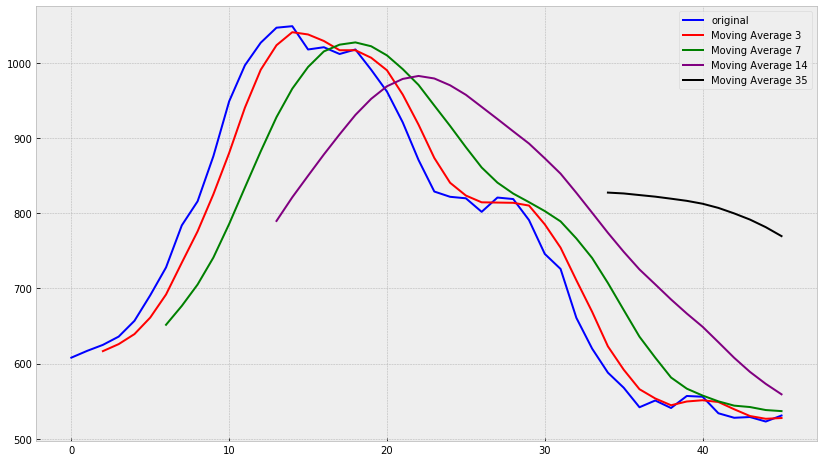

In [185]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

### WMA

In [186]:
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

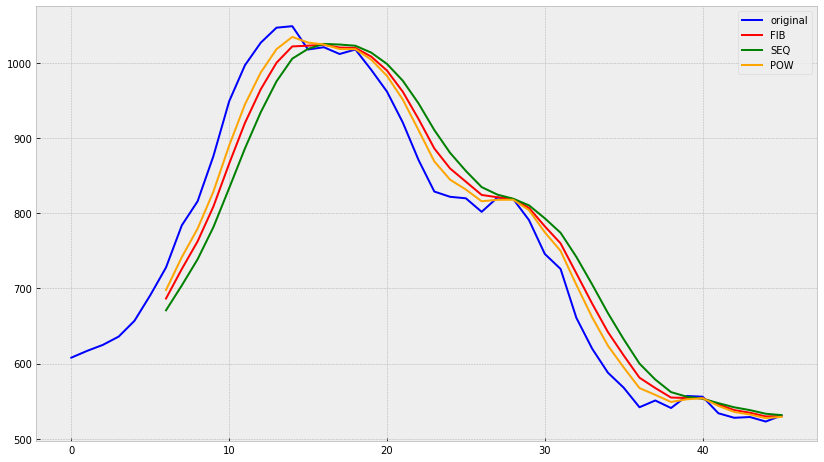

In [187]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

### ema

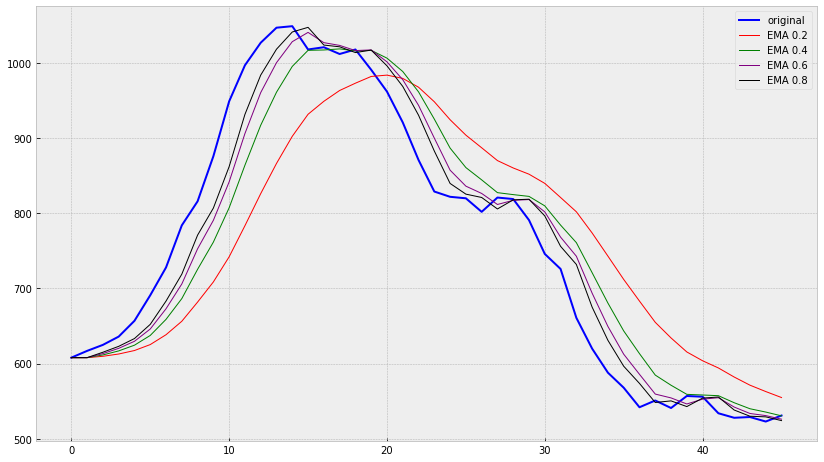

In [188]:
windows = [0.2,0.4,0.6,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = exponential_moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='EMA {}'.format(windows[i]))
    plt.legend()

### dema

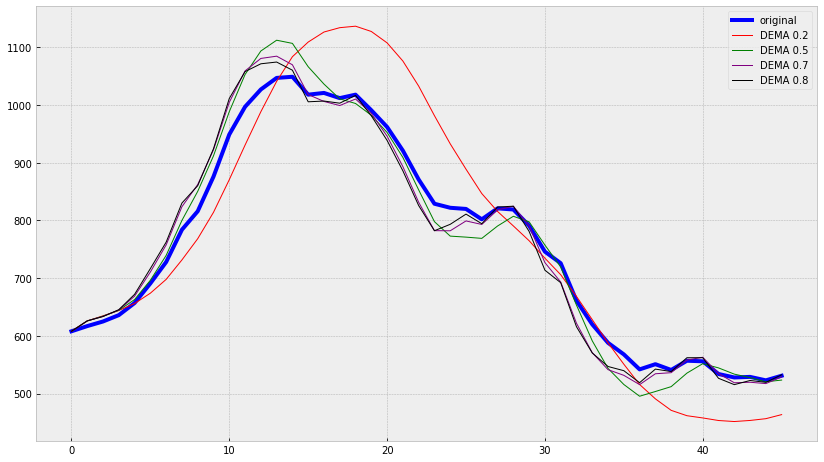

In [189]:
windows = [0.2,0.5,0.7,0.8]
win = [0.2,0.5,0.7,0.8]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original', linewidth = '4')
    for i in range(len(windows)):
        ser = double_ema(series, windows[i], win[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='DEMA {}'.format(windows[i]))
    plt.legend()

### Predict

Посмотрев на все сделанные MA можем сделать вывод, что наиболее точно структуру данных повторяют:
1. MA3
2. WMA POW
3. EMA 0.8
4. DEMA 0.8-0.8

Для них и построим предсказания

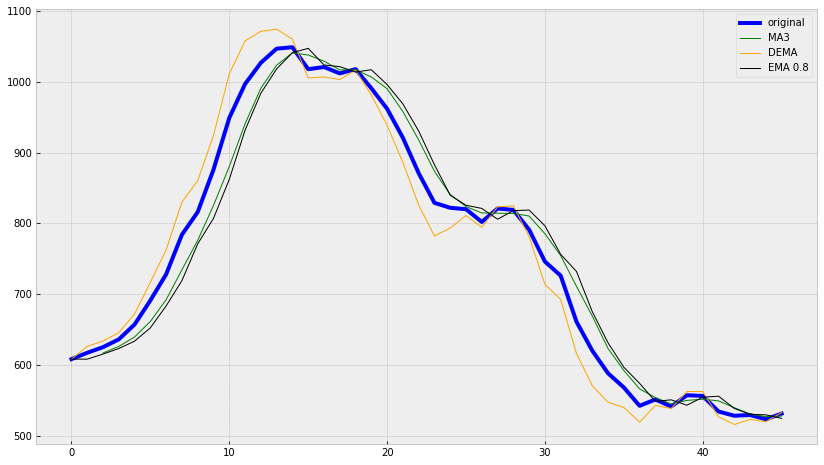

In [190]:
EMA = exponential_moving_average(series, 0.8)
DEMA  = double_ema(series, 0.8, 0.8)
MA3 = moving_average(series, 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth = 4, label='original')
    plt.plot(MA3, color='green', linewidth='1', label='MA3')
    plt.plot(DEMA, color='orange', linewidth='1', label='DEMA')
    plt.plot(EMA, color='black', linewidth='1', label='EMA 0.8')
    plt.legend()

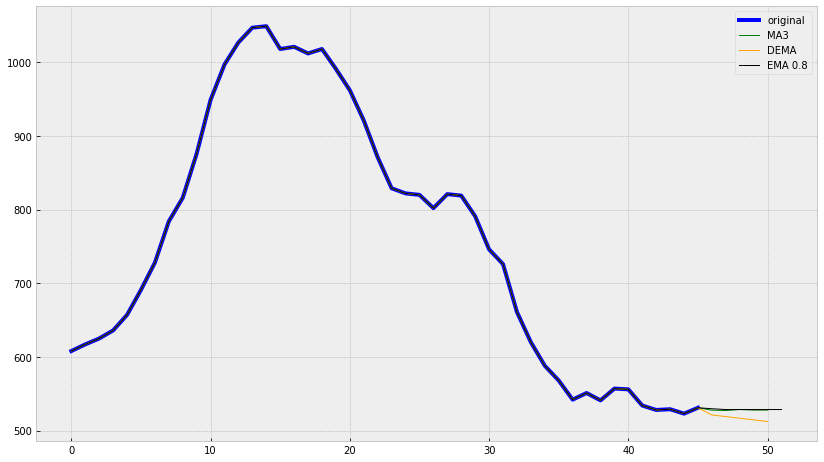

In [191]:
EMA, _ = exponential_moving_average(series, 0.8, 5)
MA3 = predict(series, 3, 5)
DEMA, _ = double_ema_with_preds(series, 0.5, 0.5, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth = 4, label='original')
    plt.plot(MA3, color='green', linewidth='1', label='MA3')
    plt.plot(DEMA, color='orange', linewidth='1', label='DEMA')
    plt.plot(EMA, color='black', linewidth='1', label='EMA 0.8')
    plt.legend()

## второй ряд

In [192]:
series = pd.read_csv("annual-industrial-production-us-.csv", delimiter=";")['Annual industrial production, U.S., 1860 to 1970']

In [193]:
series = series.drop(series.index[111])

In [194]:
series = series.astype(float)

### MA

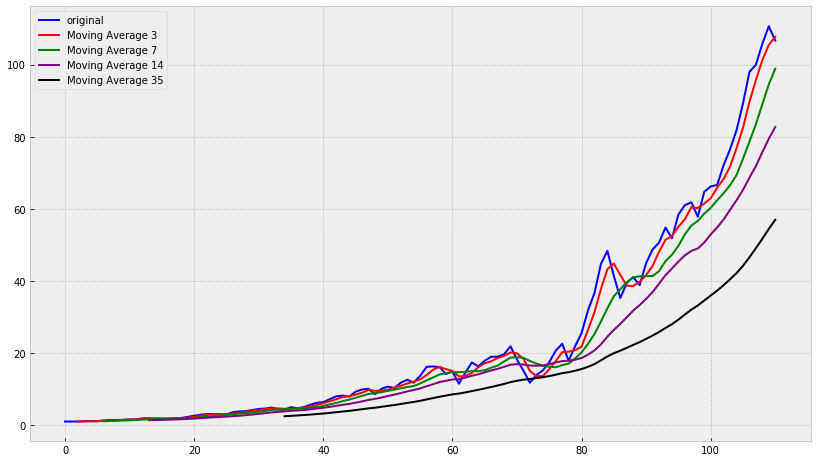

In [195]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

### WMA

In [196]:
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

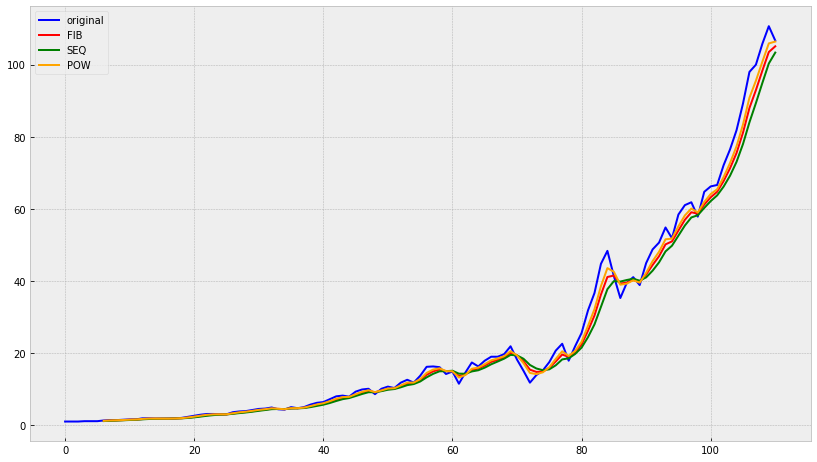

In [197]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

### ema

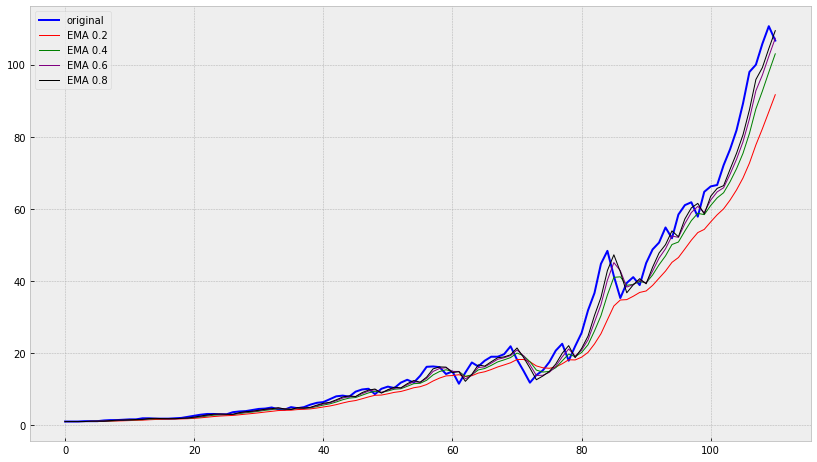

In [198]:
windows = [0.2,0.4,0.6,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = exponential_moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='EMA {}'.format(windows[i]))
    plt.legend()

### dema

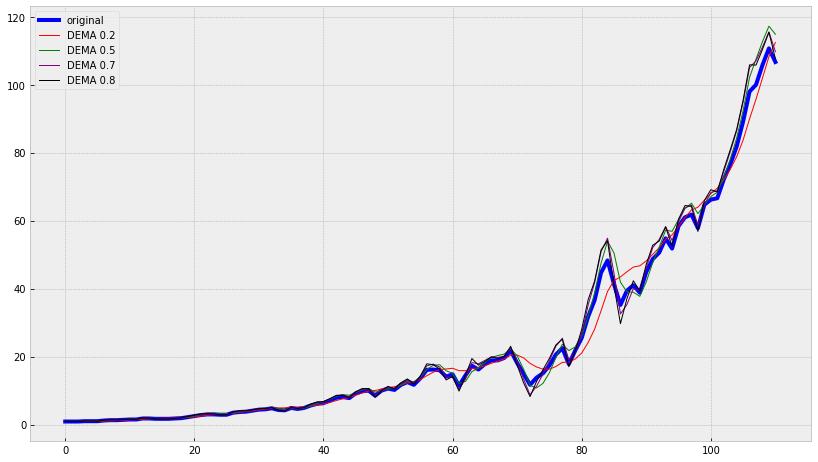

In [199]:
windows = [0.2,0.5,0.7,0.8]
win = [0.2,0.5,0.7,0.8]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original', linewidth = '4')
    for i in range(len(windows)):
        ser = double_ema(series, windows[i], win[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='DEMA {}'.format(windows[i]))
    plt.legend()

### Predict

Посмотрев на все сделанные MA можем сделать вывод, что наиболее точно структуру данных повторяют:
1. MA3
2. WMA POW
3. EMA 0.8
4. DEMA 0.2-0.2

Для них и построим предсказания

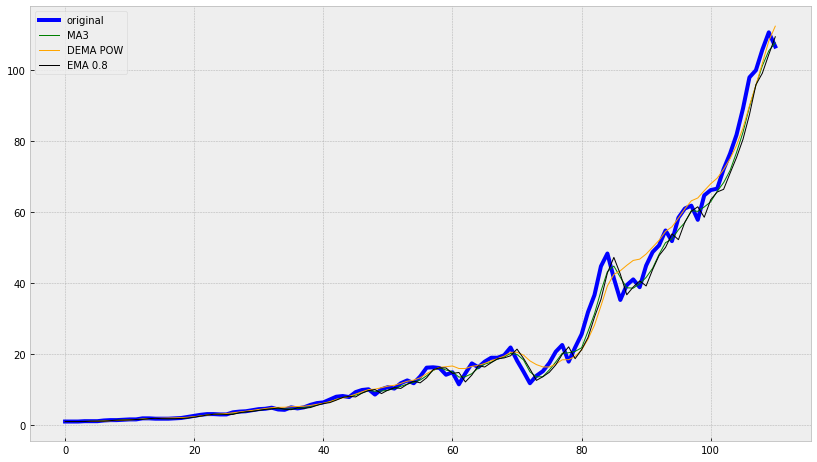

In [200]:
EMA = exponential_moving_average(series, 0.8)
DEMA  = double_ema(series, 0.2, 0.2)
MA3 = moving_average(series, 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth = 4, label='original')
    plt.plot(MA3, color='green', linewidth='1', label='MA3')
    plt.plot(DEMA, color='orange', linewidth='1', label='DEMA POW')
    plt.plot(EMA, color='black', linewidth='1', label='EMA 0.8')
    plt.legend()

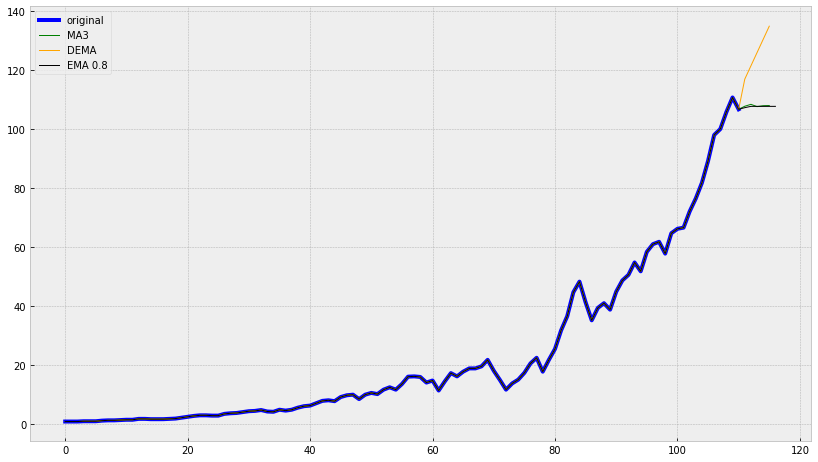

In [201]:
EMA, _ = exponential_moving_average(series, 0.8, 5)
MA3 = predict(series, 3, 5)
DEMA, _ = double_ema_with_preds(series, 0.2, 0.2, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth = 4, label='original')
    plt.plot(MA3, color='green', linewidth='1', label='MA3')
    plt.plot(DEMA, color='orange', linewidth='1', label='DEMA')
    plt.plot(EMA, color='black', linewidth='1', label='EMA 0.8')
    plt.legend()

## 4й ряд с сезонностью

In [202]:
series = pd.read_csv("monthly-gasoline-demand-ontario-.csv", delimiter=";")['Monthly gasoline demand Ontario gallon millions 1960 ? 1975']

In [203]:
series = series.drop(series.index[192])

In [204]:
series.head()

0     87695.0
1     86890.0
2     96442.0
3     98133.0
4    113615.0
Name: Monthly gasoline demand Ontario gallon millions 1960 ? 1975, dtype: float64

In [205]:
series = series.astype(float)

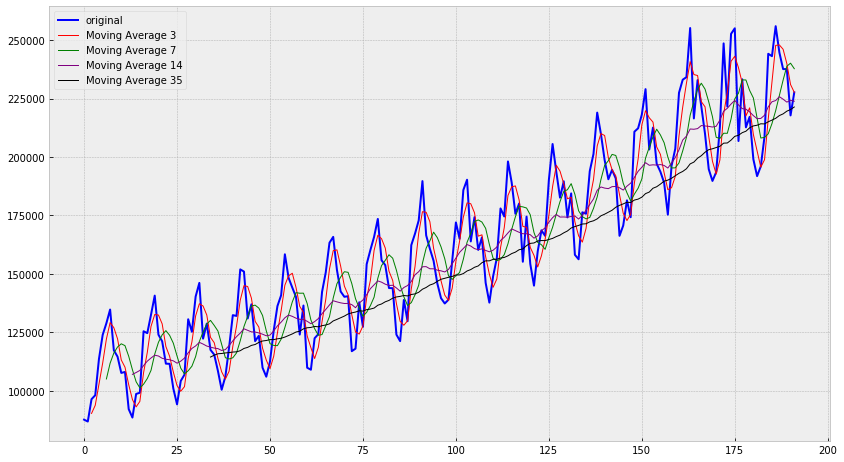

In [207]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='Moving Average {}'.format(windows[i]))
    plt.legend()

### WMA

In [209]:
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

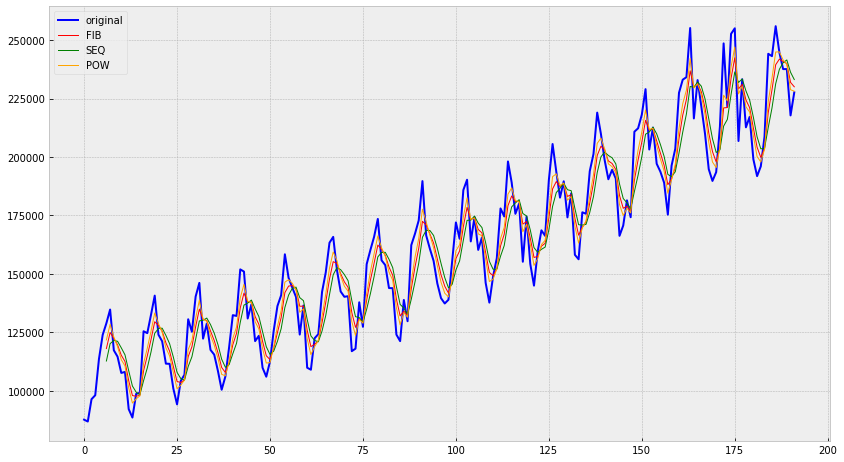

In [210]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='1', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='1', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='1', label='POW')
    plt.legend()

### ema

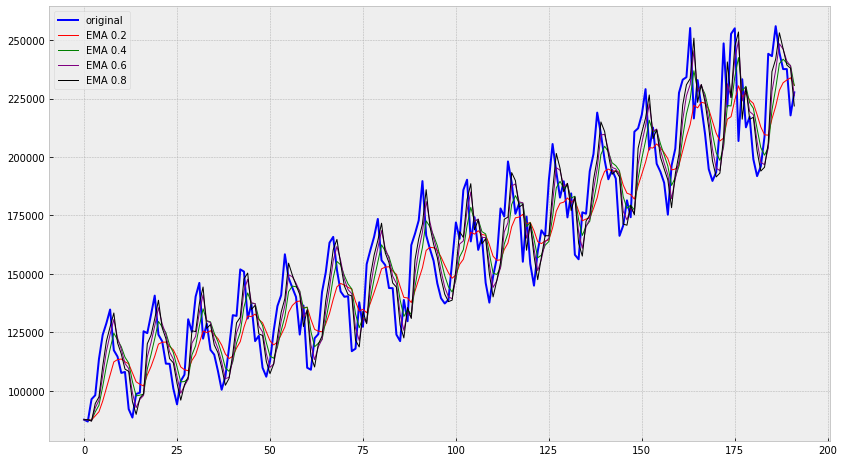

In [213]:
windows = [0.2,0.4,0.6,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth ="2", label='original')
    for i in range(len(windows)):
        ser = exponential_moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='EMA {}'.format(windows[i]))
    plt.legend()

### dema

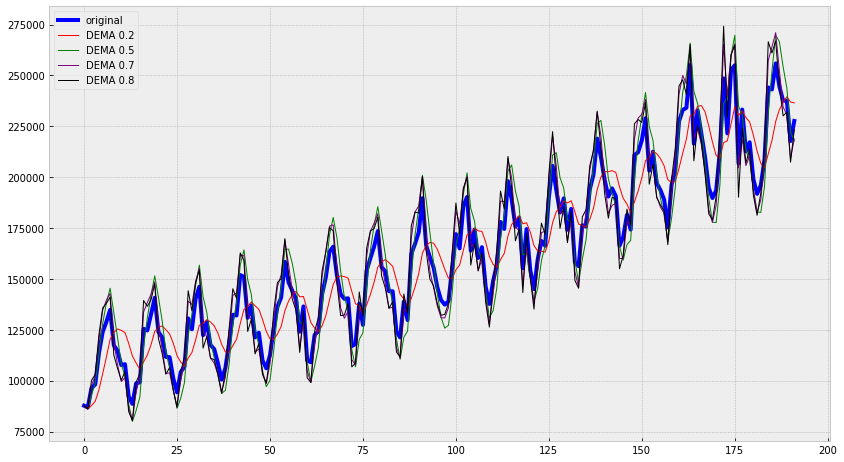

In [214]:
windows = [0.2,0.5,0.7,0.8]
win = [0.2,0.5,0.7,0.8]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original', linewidth = '4')
    for i in range(len(windows)):
        ser = double_ema(series, windows[i], win[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='DEMA {}'.format(windows[i]))
    plt.legend()

### Predict

Посмотрев на все сделанные MA можем сделать вывод, что наиболее точно структуру данных повторяют:
1. MA3
2. WMA POW
3. EMA 0.8
4. DEMA в целом, все, кроме 0.2

Для них и построим предсказания

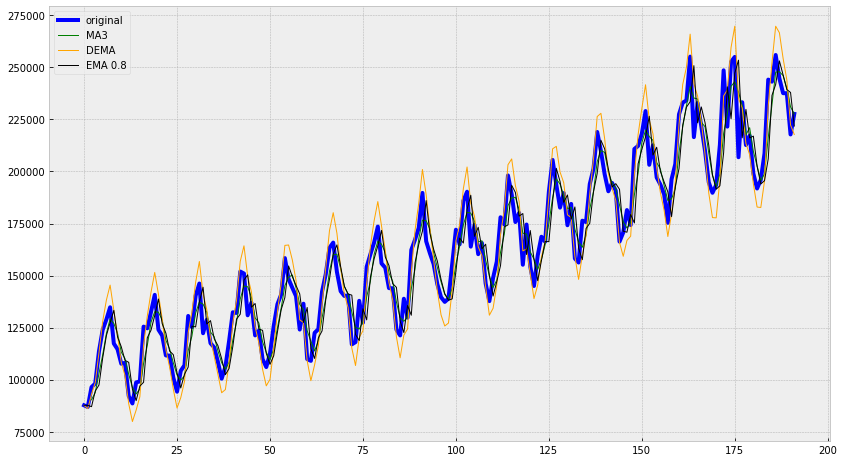

In [215]:
EMA = exponential_moving_average(series, 0.8)
DEMA  = double_ema(series, 0.5, 0.5)
MA3 = moving_average(series, 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth = 4, label='original')
    plt.plot(MA3, color='green', linewidth='1', label='MA3')
    plt.plot(DEMA, color='orange', linewidth='1', label='DEMA')
    plt.plot(EMA, color='black', linewidth='1', label='EMA 0.8')
    plt.legend()

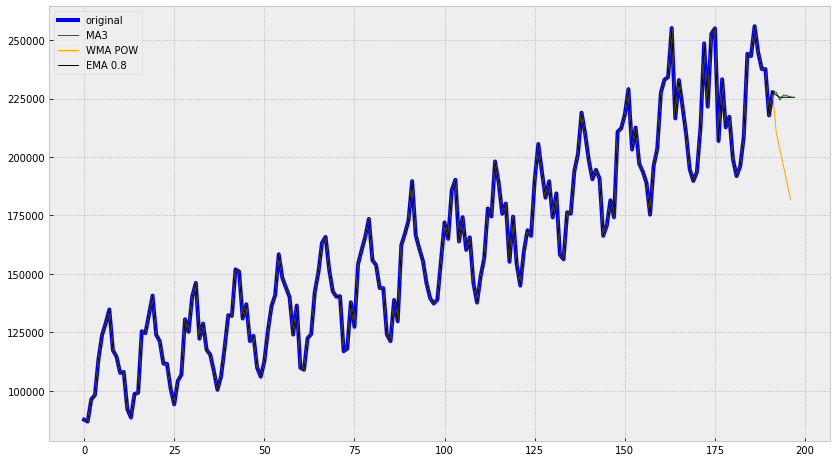

In [216]:
EMA, _ = exponential_moving_average(series, 0.8, 5)
MA3 = predict(series, 3, 5)
DEMA, _ = double_ema_with_preds(series, 0.5, 0.5, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',linewidth = 4, label='original')
    plt.plot(MA3, color='green', linewidth='1', label='MA3')
    plt.plot(DEMA, color='orange', linewidth='1', label='WMA POW')
    plt.plot(EMA, color='black', linewidth='1', label='EMA 0.8')
    plt.legend()

## Вывод

1. Меньший период простых MA дает более точное следование трендам, но, из-за этого, более чувствителен к изменениям. Возможно, для анализа имеет смысл использовать MA на MA
2. Во взвешенных средних наиболее точны средние с квадратами двойки, что объясняется более сильными весами последних значений
3. EMA в среднем показал более точные значения на больших периодах, хотя больших различий не показал - любая из выбранных кривых слишком чувствительна
4. DEMA - наилучший результат в прогнозировании